In [22]:
!pip install transformers datasets evaluate

In [23]:
import torch
import evaluate
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer, DataCollatorWithPadding

In [24]:
# HELPER FUNCTIONS
def tokenize(batch):
    return tokenizer(batch["sentence"], truncation=True, max_length=256)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels)["f1"]
    }


In [25]:
dataset = load_dataset("glue", "sst2")
dataset["train"][:5]

{'sentence': ['hide new secretions from the parental units ',
  'contains no wit , only labored gags ',
  'that loves its characters and communicates something rather beautiful about human nature ',
  'remains utterly satisfied to remain the same throughout ',
  'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up '],
 'label': [0, 0, 1, 0, 0],
 'idx': [0, 1, 2, 3, 4]}

In [53]:
# RUN THIS FOR DISTILBERT TEST


tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenized = dataset.map(tokenize, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

wandb.login(key="MY-API-KEY")
wandb.init(project="MY-WANDB-PROJECT-NAME")

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

training_args = TrainingArguments(
    output_dir="./distilbert-sst2",
    eval_strategy="steps",
    logging_strategy="steps",
    logging_steps=500,
    eval_steps=500,
    save_strategy="steps",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="wandb",
    run_name="distillbert_sst21"
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


eval/accuracy,▁▃▃▆▇▅▅▇▆▇▆▇▇▇▇▇▇██▇█████▇
eval/f1,▂▁▁▄▅▅▁▆▅▆▆▇▆▅▆▇▇▇▇▇█████▆
eval/loss,▇▅▅▃▂▃▅▃▃▃▄▅▁▃▃▃█▄▇▆▇▇▇▆▆▁
eval/runtime,▄▅▂▁▃▃▂▂▇▅▆▆▅▃▅▂▆▇▆▄▃▄▂█▆█
eval/samples_per_second,▅▄▆█▆▆▇▇▂▄▃▃▄▆▄▇▃▂▃▅▆▅▇▁▃▁
eval/steps_per_second,▅▄▆█▆▆▇▇▂▄▃▃▄▆▄▇▃▂▃▅▆▅▇▁▃▁
test/accuracy,▁
test/f1,▁
test/loss,▁
test/runtime,▁
+7,...


/tmp/ipython-input-3082692712.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1
500,0.349200,0.312103,0.872706,0.867384
1000,0.270000,0.293715,0.880734,0.887446
1500,0.236000,0.277951,0.897936,0.902305
2000,0.221700,0.361448,0.872706,0.884974
2500,0.202800,0.300734,0.901376,0.905286
3000,0.203100,0.302027,0.903670,0.908497
3500,0.201700,0.314108,0.897936,0.903575
4000,0.188400,0.280261,0.915138,0.918502
4500,0.146800,0.361981,0.909404,0.913091
5000,0.135800,0.438646,0.889908,0.898734


TrainOutput(global_step=12630, training_loss=0.14881534674577268, metrics={'train_runtime': 1665.3424, 'train_samples_per_second': 121.325, 'train_steps_per_second': 7.584, 'total_flos': 1840675124211036.0, 'train_loss': 0.14881534674577268, 'epoch': 3.0})

In [45]:
# RUN THIS FOR MINI-MODEL TEST

import torch
from torch import nn
from datasets import load_dataset
from transformers import Trainer, TrainingArguments
from decoder_only import MiniDecoder, DecoderConfig
from utils import  BPETokenizer

wandb.login(key="MY-API-KEY")
wandb.init(project="MY-WANDB-PROJECT-NAME")

dataset = load_dataset("sst2")

tokenizer = BPETokenizer(vocab_size=2048)
checkpoint = torch.load("decoder.pt", map_location="cpu")
tokenizer.merges = checkpoint["tokenizer_merges"]

max_seq_len = 128

def tokenize_fn(batch):
    input_ids = [tokenizer.encode(text, add_special_tokens=True)[-max_seq_len:] for text in batch["sentence"]]
    return {"input_ids": input_ids, "label": batch["label"]}

tokenized = dataset.map(tokenize_fn, batched=True)

def collate_fn(batch):
    input_ids = [item["input_ids"] for item in batch]
    max_len = max(len(ids) for ids in input_ids)
    padded = [ids + [tokenizer.pad_token_id]*(max_len-len(ids)) for ids in input_ids]
    attention_mask = [[1]*len(ids) + [0]*(max_len-len(ids)) for ids in input_ids]
    labels = [item["label"] for item in batch]
    return {
        "input_ids": torch.tensor(padded, dtype=torch.long),
        "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
        "labels": torch.tensor(labels, dtype=torch.long),
    }

config = DecoderConfig(
    vocab_size=tokenizer.vocab_size,
    embed_dim=256,
    num_heads=8,
    ff_dim=256,
    num_layers=6,
    dropout=0.1,
    max_seq_len=max_seq_len,
    pad_token_id=tokenizer.pad_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    use_rope=True,
    use_learned_pos=True
)

decoder_model = MiniDecoder(config)
decoder_model.load_state_dict(checkpoint["model_state"])

class DecoderForClassification(nn.Module):
    def __init__(self, decoder: MiniDecoder, num_labels: int):
        super().__init__()
        self.decoder = decoder
        self.classifier = nn.Linear(decoder.config.embed_dim, num_labels)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask=None, labels=None):
        hidden = self.decoder(input_ids, attention_mask)
        last_hidden = hidden[:, -1, :]
        logits = self.classifier(last_hidden)
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return {"loss": loss, "logits": logits}

model = DecoderForClassification(decoder_model, num_labels=2)

import evaluate
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels)["f1"]
    }

training_args = TrainingArguments(
    output_dir="./decoder-sst2",
    eval_strategy="steps",
    logging_strategy="steps",
    logging_steps=500,
    eval_steps=500,
    save_strategy="steps",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="wandb",
    run_name="decoder_sst2"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    compute_metrics=compute_metrics,
    tokenizer=None,
    data_collator=collate_fn
)

trainer.train()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


eval/accuracy,▁▇▇█▇███████████████████████▁▂▂▃▃▄▄
eval/f1,▁▇▇█▇███████████████████████▁▁▁▁▂▂▁
eval/loss,█▁▁▁▃▂▁▂▂▃▄▃▂▂▂▃▂▃▄▅▄▅▄▄▄▄▁▁█▇█▆▆▆▆
eval/runtime,▄▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▁▁▄▁▁▁▇
eval/samples_per_second,▄▂▂▂▂▁▂▂▂▁▂▂▂▂▂▂▂▁▂▁▂▂▂▂▂▂▁▁██▄███▂
eval/steps_per_second,▄▂▂▂▂▁▂▂▂▁▂▂▂▂▂▂▂▁▂▁▂▂▂▂▂▂▁▁██▄███▂
test/accuracy,▁▁
test/f1,▁▁
test/loss,▁▁
test/runtime,▁█
+7,...


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

/tmp/ipython-input-3880596826.py:102: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1
500,0.683000,0.638303,0.619266,0.689139
1000,0.641900,0.600972,0.657110,0.666667
1500,0.589800,0.600476,0.670872,0.664327
2000,0.557400,0.556713,0.717890,0.720455
2500,0.539700,0.536180,0.739679,0.738178
3000,0.517900,0.552148,0.715596,0.735043
3500,0.500000,0.594692,0.707569,0.670968
4000,0.487600,0.549303,0.743119,0.743119
4500,0.459300,0.562464,0.733945,0.738739
5000,0.436200,0.547985,0.738532,0.750000


TrainOutput(global_step=12630, training_loss=0.41895248431208015, metrics={'train_runtime': 347.8483, 'train_samples_per_second': 580.848, 'train_steps_per_second': 36.309, 'total_flos': 0.0, 'train_loss': 0.41895248431208015, 'epoch': 3.0})

In [46]:
results = trainer.evaluate()
results

{'eval_loss': 0.5045554637908936,
 'eval_accuracy': 0.7545871559633027,
 'eval_f1': 0.7562642369020501,
 'eval_runtime': 0.5244,
 'eval_samples_per_second': 1662.934,
 'eval_steps_per_second': 104.887,
 'epoch': 3.0}

In [47]:
trainer.save_model("./saved_our_sst2")
# tokenizer.save_pretrained("./saved_our_sst2")

In [48]:
predictions, labels, _ = trainer.predict(tokenized["validation"])

preds = torch.argmax(torch.tensor(predictions), dim=-1).numpy()

for i in range(10):
    sentence = dataset["validation"][i]["sentence"]
    true_label = dataset["validation"][i]["label"]
    pred_label = preds[i]
    print(f"Sentence: {sentence}")
    print(f"True label: {true_label}, Predicted: {pred_label}")
    print("—--")

Sentence: it 's a charming and often affecting journey . 
True label: 1, Predicted: 1
—--
Sentence: unflinchingly bleak and desperate 
True label: 0, Predicted: 0
—--
Sentence: allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . 
True label: 1, Predicted: 0
—--
Sentence: the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . 
True label: 1, Predicted: 1
—--
Sentence: it 's slow -- very , very slow . 
True label: 0, Predicted: 0
—--
Sentence: although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women . 
True label: 1, Predicted: 1
—--
Sentence: a sometimes tedious film . 
True label: 0, Predicted: 0
—--
Sentence: or doing last year 's taxes with your ex-wife . 
True label: 0, Predicted: 1
—--
Sentence: you do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance . 
True label: 1, Pre

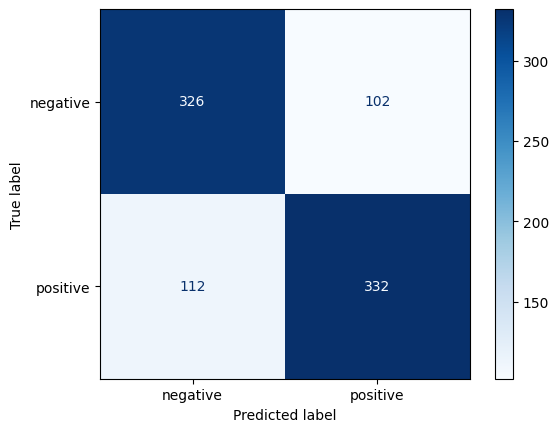

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["negative", "positive"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

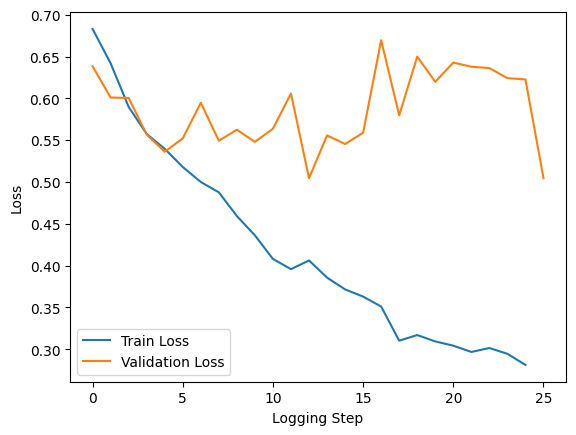

In [50]:
import matplotlib.pyplot as plt

train_losses = [x['loss'] for x in trainer.state.log_history if 'loss' in x]
eval_losses = [x['eval_loss'] for x in trainer.state.log_history if 'eval_loss' in x]

plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Logging Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

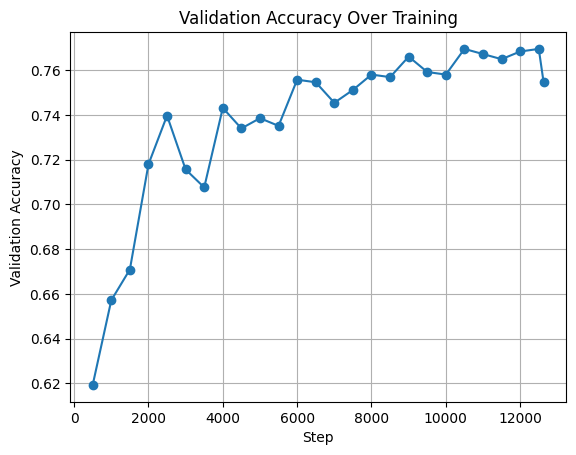

In [51]:
import matplotlib.pyplot as plt

# Extract eval accuracy from log history
eval_acc = [x["eval_accuracy"] for x in trainer.state.log_history if "eval_accuracy" in x]
eval_steps = [x["step"] for x in trainer.state.log_history if "eval_accuracy" in x]

plt.plot(eval_steps, eval_acc, marker='o')
plt.xlabel("Step")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Over Training")
plt.grid(True)
plt.show()